### Demand Forecasting for retail chain

#### Machine Learning Project
- Understanding the Problem Statement
- Data Collection
- Data Checks to perform
- Exploratory data analysis
- Data Pre-Processing
- Model Training
- Choose best model

##### 1) Problem statement
This project focuses on item-level demand forecasting. \
The primary objective is to forecast the next 14 days of sales (units sold) at a Store × Item × Day granularity, closely reflecting real-world retail demand planning systems.

##### 2) Data Collection
The dataset spans January 2024 to December 2025 and contains 50,000 transaction records, incorporating key business drivers such as promotions, holidays, pricing, footfall, and external factors like weather and temperature.

##### 2.1 Import Data and Required Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("data/walmart_item_level_demand_forecasting.csv", parse_dates=['date'])

In [3]:
df.head()

,date,store_id,category,sub_category,item_id,is_weekend,is_holiday,holiday_type,promotion_type,promotion_discount_pct,avg_price,temperature_c,weather_condition,footfall,units_sold,revenue
0,2024-01-01,Store_11,Electronics,Appliances,Ele_App_10,0,1,NewYear,Discount,36.0,275.30,32.9,Cloudy,87,29,7983.70
1,2024-01-01,Store_7,Clothing,Men,Clo_Men_7,0,1,NewYear,Discount,16.9,94.80,24.6,Storm,305,44,4171.20
2,2024-01-01,Store_19,Household,Cleaning,Hou_Cle_5,0,1,NewYear,NaN,0.0,157.77,21.6,Sunny,348,33,5206.41
3,2024-01-01,Store_20,Clothing,Kids,Clo_Kid_3,0,1,NewYear,NaN,0.0,140.95,33.1,Sunny,357,15,2114.25
4,2024-01-01,Store_19,Pharmacy,OTC,Pha_OTC_5,0,1,NewYear,NaN,0.0,296.31,22.0,Sunny,129,12,3555.72


In [4]:
df.shape

(60000, 16)

#### 2.2 Dataset information

Hierarchy
| Level        | Column         |
| ------------ | -------------- |
| Store        | `store_id`     |
| Category     | `category`     |
| Sub-category | `sub_category` |
| Item (SKU)   | `item_id`      |

Target
| Column       | Description                             |
| ------------ | --------------------------------------- |
| `units_sold` | Daily item-level demand (forecast this) |

Time & Events

- date
- is_weekend
- is_holiday
- holiday_type

Commercial Drivers
- promotion_type
- promotion_discount_pct
- avg_price
- footfall

External Factors

- temperature_c
- weather_condition

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    60000 non-null  datetime64[ns]
 1   store_id                60000 non-null  object        
 2   category                60000 non-null  object        
 3   sub_category            60000 non-null  object        
 4   item_id                 60000 non-null  object        
 5   is_weekend              60000 non-null  int64         
 6   is_holiday              60000 non-null  int64         
 7   holiday_type            693 non-null    object        
 8   promotion_type          60000 non-null  object        
 9   promotion_discount_pct  60000 non-null  float64       
 10  avg_price               60000 non-null  float64       
 11  temperature_c           60000 non-null  float64       
 12  weather_condition       60000 non-null  object

In [39]:
#Time covergence and granularity check
df['date'].min(), df['date'].max()

(Timestamp('2024-01-01 00:00:00'), Timestamp('2025-12-31 00:00:00'))

#### 3) Data checks

In [69]:
df.isna().sum()

date                          0
store_id                      0
category                      0
sub_category                  0
item_id                       0
is_weekend                    0
is_holiday                    0
holiday_type              59307
promotion_type                0
promotion_discount_pct        0
avg_price                     0
temperature_c                 0
weather_condition             0
footfall                      0
units_sold                    0
revenue                       0
month                         0
dtype: int64

In [77]:
# Only null values in holiday type, let's check it's due to there's no holidays
df['holiday_type'].unique()

array(['NewYear', nan, 'Easter', 'Diwali', 'Christmas'], dtype=object)

In [80]:
df['holiday_type'] = df['holiday_type'].fillna('no_holiday')

In [81]:
df.isnull().sum()

date                      0
store_id                  0
category                  0
sub_category              0
item_id                   0
is_weekend                0
is_holiday                0
holiday_type              0
promotion_type            0
promotion_discount_pct    0
avg_price                 0
temperature_c             0
weather_condition         0
footfall                  0
units_sold                0
revenue                   0
month                     0
dtype: int64

In [82]:
df.describe()

,date,is_weekend,is_holiday,promotion_discount_pct,avg_price,temperature_c,footfall,units_sold,revenue,month
count,60000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,2024-12-30 14:56:31.200000,0.283700,0.011550,8.955558,151.829905,27.501430,339.947600,24.254950,3685.343821,6.512800
min,2024-01-01 00:00:00,0.000000,0.000000,0.000000,3.000000,15.000000,80.000000,3.000000,33.000000,1.000000
25%,2024-06-29 00:00:00,0.000000,0.000000,0.000000,77.480000,21.200000,210.000000,18.000000,1681.635000,4.000000
50%,2024-12-31 00:00:00,0.000000,0.000000,0.000000,151.940000,27.500000,340.000000,23.000000,3308.990000,7.000000
75%,2025-07-03 00:00:00,1.000000,0.000000,18.000000,225.890000,33.700000,470.000000,29.000000,5221.920000,10.000000
max,2025-12-31 00:00:00,1.000000,1.000000,40.000000,300.000000,40.000000,599.000000,81.000000,23048.410000,12.000000
std,NaN,0.450797,0.106849,12.731444,85.807989,7.221047,150.067757,8.252039,2529.142137,3.450372


In [83]:
# Check the store_ids


for col in ['store_id', 'category', 'sub_category', 'item_id', 'is_weekend', 'is_holiday', 'holiday_type', 'promotion_type', 'weather_condition']:
    print(col, "\n", df[col].unique(), "\n")

store_id 
 ['Store_11' 'Store_7' 'Store_19' 'Store_20' 'Store_2' 'Store_6' 'Store_10'
 'Store_17' 'Store_5' 'Store_15' 'Store_14' 'Store_8' 'Store_9' 'Store_13'
 'Store_1' 'Store_12' 'Store_18' 'Store_16' 'Store_3' 'Store_4'] 

category 
 ['Electronics' 'Clothing' 'Household' 'Pharmacy' 'Grocery'] 

sub_category 
 ['Appliances' 'Men' 'Cleaning' 'Kids' 'OTC' 'Women' 'Accessories' 'Mobile'
 'Decor' 'Kitchen' 'Snacks' 'Personal Care' 'Dairy' 'Beverages'] 

item_id 
 ['Ele_App_10' 'Clo_Men_7' 'Hou_Cle_5' 'Clo_Kid_3' 'Pha_OTC_5' 'Hou_Cle_3'
 'Clo_Wom_2' 'Ele_Acc_5' 'Ele_Mob_4' 'Hou_Dec_6' 'Hou_Kit_6' 'Ele_Acc_1'
 'Gro_Sna_9' 'Pha_Per_3' 'Ele_Mob_3' 'Clo_Men_3' 'Pha_Per_6' 'Gro_Dai_2'
 'Pha_OTC_10' 'Clo_Men_10' 'Ele_App_3' 'Ele_Acc_6' 'Hou_Dec_7' 'Clo_Men_9'
 'Hou_Dec_8' 'Hou_Dec_10' 'Ele_App_5' 'Hou_Dec_5' 'Gro_Bev_1' 'Hou_Dec_2'
 'Ele_Mob_8' 'Hou_Cle_4' 'Hou_Cle_2' 'Gro_Sna_6' 'Clo_Wom_3' 'Ele_Mob_9'
 'Pha_Per_7' 'Gro_Dai_10' 'Pha_OTC_6' 'Hou_Cle_1' 'Ele_App_9' 'Ele_App_6'
 'Gro_Sna_2' 'Ho

In [84]:
# Replace the null promotion type with 'No_discount'
df['promotion_type'] = df['promotion_type'].fillna('No_discount')
df['promotion_type'].unique()

array(['Discount', 'No_discount', 'BOGO', 'Clearance'], dtype=object)

#### 4) Exploring the data

In [85]:
# Ensures each SKU has enough history
df.groupby('item_id')['date'].nunique().describe()

count    140.000000
mean     324.707143
std       14.850089
min      287.000000
25%      313.000000
50%      325.000000
75%      335.000000
max      363.000000
Name: date, dtype: float64

In [86]:
# Target varaible analysis - unit sold

In [87]:
# Distribution of daily sales
df['units_sold'].describe()

count    60000.000000
mean        24.254950
std          8.252039
min          3.000000
25%         18.000000
50%         23.000000
75%         29.000000
max         81.000000
Name: units_sold, dtype: float64

<Axes: >

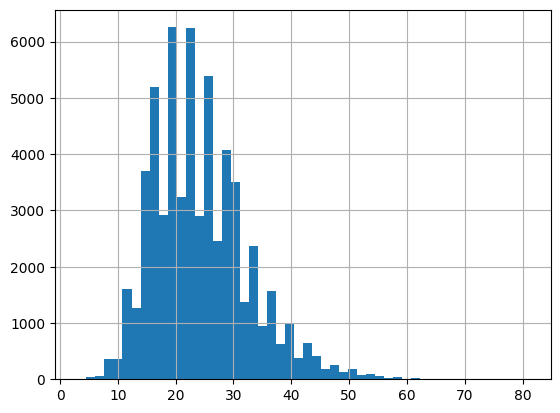

In [88]:
df['units_sold'].hist(bins=50)

In [89]:
# Right skewed distribution
# Presence of low and high-selling SKUs

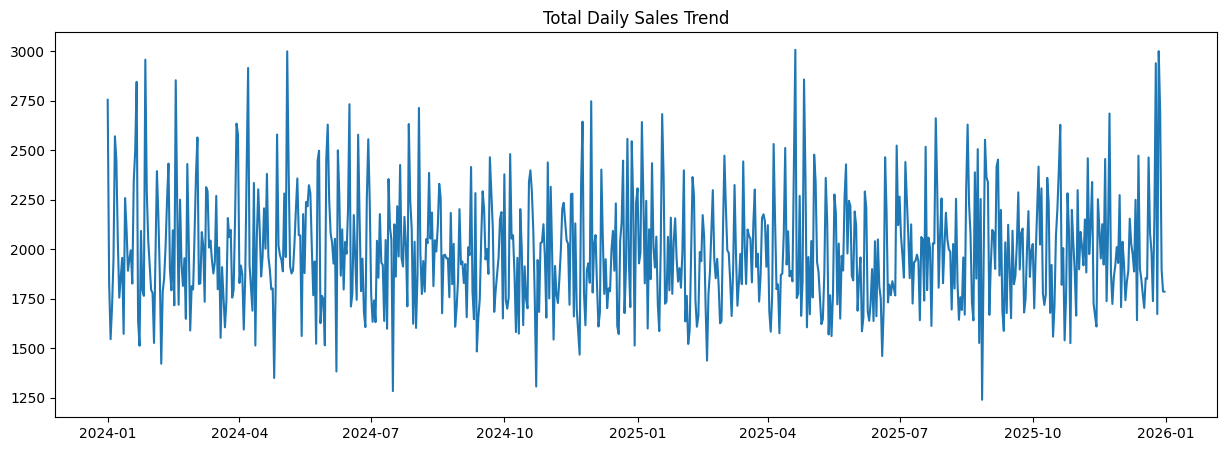

In [90]:
#Sales trend over time
daily_sales = df.groupby('date')['units_sold'].sum()
plt.figure(figsize=(15,5))
plt.plot(daily_sales)
plt.title("Total Daily Sales Trend")
plt.show()

In [91]:
# Can identify seasonal spikes

In [92]:
# Seaonlity Analysis

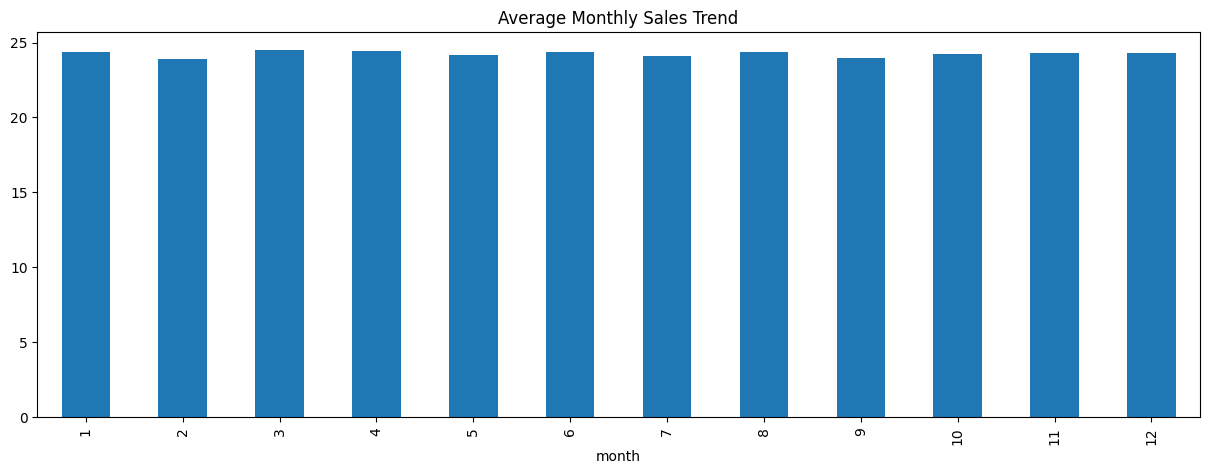

In [93]:
# Monhtly Seasonlaity'
df['month'] = df['date'].dt.month
monthly_sales = df.groupby('month')['units_sold'].mean()
plt.figure(figsize=(15,5))
monthly_sales.plot(kind='bar')
plt.title("Average Monthly Sales Trend")
plt.show()


In [94]:
# Not seen monthly sales variations

In [95]:
# Weekend vs Weekday Impact
df.groupby('is_weekend')['units_sold'].mean()

is_weekend
0    22.904998
1    27.663377
Name: units_sold, dtype: float64

In [96]:
# Weekend shows higher average demand

In [97]:
# Holiday impact analysis
df.groupby('is_holiday')['units_sold'].mean()

is_holiday
0    24.180653
1    30.613276
Name: units_sold, dtype: float64

In [98]:
df.groupby("holiday_type")["units_sold"].mean().sort_values(ascending=False)


holiday_type
Easter        34.269939
Christmas     29.718919
NewYear       29.436047
Diwali        29.294798
no_holiday    24.180653
Name: units_sold, dtype: float64

In [99]:
# Holiday significantly boost demand

In [100]:
# Promotion Effectiveness
df.groupby('promotion_type')['units_sold'].mean()

promotion_type
BOGO           30.065706
Clearance      32.058943
Discount       26.611646
No_discount    21.252374
Name: units_sold, dtype: float64

In [101]:
df.groupby('promotion_type')['units_sold'].median()

promotion_type
BOGO           29.0
Clearance      31.0
Discount       26.0
No_discount    21.0
Name: units_sold, dtype: float64

In [102]:
# Promotion increased demands
# Discount and BOGO outperform discount

In [103]:
# Price vs Demand Relationship
df[['avg_price','units_sold']].corr()

,avg_price,units_sold
avg_price,1.000000,0.003837
units_sold,0.003837,1.000000


<Axes: xlabel='avg_price', ylabel='units_sold'>

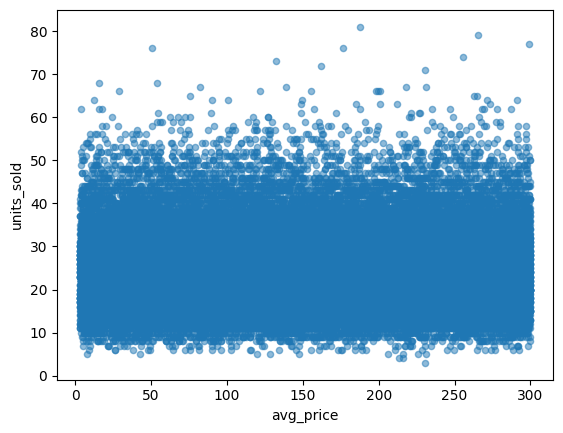

In [104]:
df.plot.scatter(x='avg_price', y='units_sold', alpha=0.5)

In [62]:
# Weak relationship
# confirms non-linear relationship

In [63]:
# Category & Item-Level Analysis
df.groupby('category')['units_sold'].mean().sort_values()

category
Electronics    24.171455
Clothing       24.235433
Pharmacy       24.253240
Household      24.281564
Grocery        24.332608
Name: units_sold, dtype: float64

In [64]:
top_items = (
    df.groupby('category')['units_sold']
    .sum()
    .sort_values(ascending=False)
)
top_items

category
Household      314252
Electronics    312972
Grocery        312966
Clothing       307378
Pharmacy       207729
Name: units_sold, dtype: int64

In [65]:
# According to this identifies ast vs slow movers
# It may useful for ABC classification & differentiated forecasting stragtegies

In [66]:
# External factor impact
# Weather condition
df.groupby("weather_condition")["units_sold"].mean()

weather_condition
Cloudy    24.286888
Rainy     24.268775
Storm     24.228411
Sunny     24.235275
Name: units_sold, dtype: float64

In [67]:
# Footfall
df[['footfall','units_sold']].corr()

,footfall,units_sold
footfall,1.000000,0.395974
units_sold,0.395974,1.000000


In [ ]:
df.columns

Index(['date', 'store_id', 'category', 'sub_category', 'item_id', 'is_weekend',
       'is_holiday', 'holiday_type', 'promotion_type',
       'promotion_discount_pct', 'avg_price', 'temperature_c',
       'weather_condition', 'footfall', 'units_sold', 'revenue', 'month'],
      dtype='object')